In [31]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [32]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/SexSmallBrain_ukb_without_residualization.csv"
label = "Sex"
max_iter = 2000
cv = 3

In [33]:
participants = pd.read_csv(participants_file, index_col=0)


In [34]:
participants = participants[participants.isBigBrain==0]

In [35]:
participants = participants[["Sex", "BrainVolumeFreeSurfer_mm3"]]

In [36]:
def closest_point(point, points):
    """ Find closest point from a list of points. """
    return np.argsort((points-point)**2)[:10]

In [37]:
participants

,Sex,BrainVolumeFreeSurfer_mm3
participant_id,,
sub-1188492,0,997615.0
sub-2348409,0,1002614.0
sub-2214448,1,1012144.0
sub-5790117,0,1007438.0
sub-3794733,0,964232.0
...,...,...
sub-1734788,0,1029931.0
sub-1673986,0,1000852.0
sub-5224110,0,997299.0


In [8]:
females = participants[participants.Sex==0].copy()
males = participants[participants.Sex==1].copy()

females["chosen"] = 0
for one_male in males.iloc[:,1]:
    chosen_rows = closest_point(one_male, females.iloc[:,1])
    for chosen_row in chosen_rows:
        if females.iloc[chosen_row, 2] == 0:
            females.iloc[chosen_row, 2] = 1
            break

participants = pd.concat([males, females[females.chosen==1][["Sex", "BrainVolumeFreeSurfer_mm3"]]])

In [9]:
# participants[participants.Sex==0]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [10]:
# participants[participants.Sex==1]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [11]:
participants = participants[[label]].dropna()

In [12]:
# participants.hist()

In [13]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [14]:
model_paths = get_model_paths(path_champollion)

In [15]:
model_paths[:5]

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1']

In [16]:
def compute(model_path):
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label, "folds"]].merge(embeddings, left_index=True, right_index=True)
    
    # Classifies
    X = merged.drop([label, "folds"], axis=1)
    Y = merged[label]
    groups = merged["folds"]
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    model = LogisticRegression(max_iter=max_iter, random_state=1)
    logo = LeaveOneGroupOut()
    cv = logo.split(X, Y, groups)
    res = cross_val_score(model, X, Y, cv=cv, scoring='roc_auc')
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(res)
    
    # Returns result
    return (region, res.mean(), res.std(), model_name, region_path, model_path)

In [17]:
def iterative_split_through_sorting_shuffle(df, n_splits, stratify_columns, random_state):
    """Custom iterative train test split which
    maintains balanced representation.
    """
    # Dataframe random row shuffle + sorting according to stratify_columns
    sorted = df.sample(frac=1, random_state=random_state).sort_values(stratify_columns)
    # for each fold, we take one row every n_splits rows
    folds = [sorted.iloc[i::n_splits, :] for i in range(n_splits)]
    # Further shuffling
    folds = [fold.sample(frac=1, random_state=random_state) for fold in folds]
    random.Random(random_state).shuffle(folds)
    return folds

In [18]:
def print_results(parent, folds, col, verbose=True):

    # For each conbination of labels, prints the number of rows for each fold
    # having this combination
    total_errors = 0
    n_splits = len(folds)
    if verbose:
        print("query   : #rows      : #rows per fold\n")

    for col0 in parent[col[0]].unique():
        df = parent.query(f"{col[0]}==@col0")
        len_query = len(df)
        if verbose:
            print(f"{col0}: total = {len_query} : per fold =", end = ' ')
        for fold in folds:
            df0 = fold.query(f"{col[0]}==@col0")
            len_query_fold = len(df0)
            if abs(len_query_fold-len_query/n_splits) >= 2:
                total_errors += 1
            if verbose:
                print(f"{len_query_fold} -", end= ' ')
        if verbose:
            print("")

    # Prints the statistics and the number of stratification errors
    expected_total_length = len(parent)
    total_length = 0
    total_mismatches = 0
    print("\nlengths of folds : ", end = ' ')
    for fold in folds:
        len_fold = len(fold)
        print(len_fold, end=' ')
        total_length += len_fold
        if abs(len_fold-expected_total_length/n_splits) >= 2:
            total_mismatches += 1
    print(f"\nExpected total_length = {expected_total_length}")
    print(f"Effective total_length = {total_length}")

    print(f"total number of stratification errors: {total_errors}")
    print(f"total number of mismatched fold sizes : {total_mismatches}")

In [19]:
folds = iterative_split_through_sorting_shuffle(participants, cv, ['Sex'], 1)

In [20]:
print_results(participants, folds, ["Sex"])

query   : #rows      : #rows per fold

1: total = 296 : per fold = 98 - 99 - 99 - 
0: total = 296 : per fold = 99 - 98 - 99 - 

lengths of folds :  197 197 198 
Expected total_length = 592
Effective total_length = 592
total number of stratification errors: 0
total number of mismatched fold sizes : 0


In [21]:
participants["folds"] = -1
for i, fold in enumerate(folds):
    participants.loc[fold.index, "folds"] = i

In [22]:
result = []
for model_path in model_paths:
    result.append(compute(model_path))

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
[0.70917108 0.7739645  0.71912879]
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
[0.67619048 0.7765286  0.74564394]
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
[0.59047619 0.46035503 0.50340909]
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
[0.63315697 0.61913215 0.57064394]
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
[0.74620811 0.74773176 0.72651515]
Treating S.C.-sylv._right: SC-sylv_right/11-43-38_3 : /neur

In [23]:
df = pd.DataFrame(result, columns=['region', 'roc_auc', 'roc_auc_std', 'model_name', 'region_path', 'model_path'])

In [24]:
df

,region,roc_auc,roc_auc_std,model_name,region_path,model_path
0,S.C.-sylv._left,0.734088,0.028488,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,0.732788,0.041959,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...
2,S.F.inter.-S.F.sup._left,0.518080,0.054125,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...
3,S.T.i.-S.T.s.-S.T.pol._right,0.607644,0.026782,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...
4,F.Coll.-S.Rh._right,0.740152,0.009663,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
71,S.F.inter.-S.F.sup._right,0.576902,0.034105,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...
72,S.T.s._left,0.672140,0.016629,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...
73,F.C.M.post.-S.p.C._right,0.663570,0.017411,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...
74,ORBITAL_right,0.661216,0.016600,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...


In [25]:
df['side'] = df['region'].str.split('_').str[-1]

In [26]:
def plot_horizontal(res, region_name, ax, AUC_name, std_auc_name, AUC2_name, std_auc2_name, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=AUC_name, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=0.5, color='black', linestyle='-')
    ax.barh(res[region_name], res[AUC2_name], fill=True, color='lightgray')
    ax.errorbar(res[AUC_name], res[region_name], xerr=res[std_auc_name], fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    ax.set_xlim((0.45, 1.0))
    ax.set_title(title)


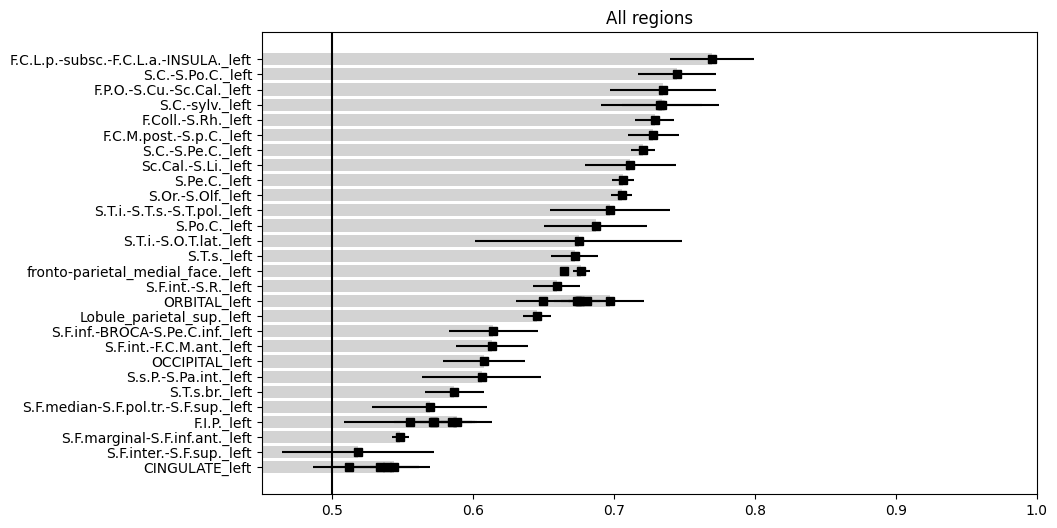

In [27]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "roc_auc", "roc_auc_std", "roc_auc", "roc_auc_std", True, "All regions")
plt.show()

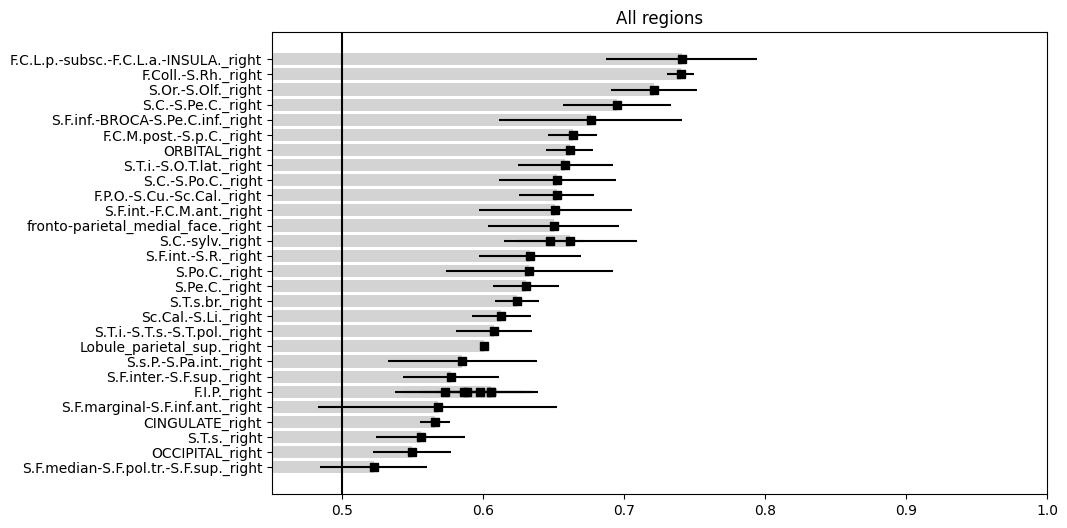

In [28]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "roc_auc", "roc_auc_std", "roc_auc", "roc_auc_std", True, "All regions")
plt.show()

In [29]:
df

,region,roc_auc,roc_auc_std,model_name,region_path,model_path,side
0,S.C.-sylv._left,0.734088,0.028488,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,0.732788,0.041959,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
2,S.F.inter.-S.F.sup._left,0.518080,0.054125,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
3,S.T.i.-S.T.s.-S.T.pol._right,0.607644,0.026782,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.Coll.-S.Rh._right,0.740152,0.009663,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
71,S.F.inter.-S.F.sup._right,0.576902,0.034105,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...,right
72,S.T.s._left,0.672140,0.016629,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...,left
73,F.C.M.post.-S.p.C._right,0.663570,0.017411,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...,right
74,ORBITAL_right,0.661216,0.016600,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...,right


In [30]:
df.to_csv(output_filename)